In [1]:
# =============================================================================
# Project Setup: Initializing Environment and Exploring Dataset Directory
# Author: Anumula Deepak Maruthi
# Description: Custom environment setup for a financial fraud detection project
# =============================================================================

# Essential libraries for data handling and numerical operations
import numpy as np       # For numerical computations
import pandas as pd      # For data processing and manipulation

# Operating system utilities for file and directory management
import os

# Displaying all files present within the dataset directory
# (Directory path may vary depending on platform/environment)
dataset_path = '/kaggle/input'

print("Scanning dataset directory...\n")
for root_dir, _, file_list in os.walk(dataset_path):
    for file_name in file_list:
        print(f"Found: {os.path.join(root_dir, file_name)}")

# -------------------------------------------------------------------
# Notes:
# - You can use '/kaggle/working/' to store output files up to 20GB.
# - Temporary files can be stored in '/kaggle/temp/' but will be deleted once session ends.
# -------------------------------------------------------------------


Scanning dataset directory...



In [2]:
# =============================================================================
# Module Imports for Modeling, Evaluation, and Visualization
# Author: Anumula Deepak Maruthi
# =============================================================================

# Scikit-learn: For model evaluation, cross-validation, and parameter tuning
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import classification_report, confusion_matrix

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import tensorflow as tf

# Utilities for randomness and progress monitoring
import random
from statistics import mean
from tqdm.auto import tqdm  # Using auto for better compatibility in notebooks and scripts

# Suppress TensorFlow warnings for cleaner output (optional)
tf.get_logger().setLevel('ERROR')


In [3]:
# =============================================================================
# Handling Class Imbalance with SMOTE (Synthetic Minority Oversampling Technique)
# =============================================================================

# Imbalanced-learn library for advanced sampling techniques
import imblearn
from imblearn.over_sampling import SMOTE

# Utility for summarizing class distributions
from collections import Counter

# Display installed imbalanced-learn version (useful for reproducibility)
print(f"[INFO] imbalanced-learn version: {imblearn.__version__}")


[INFO] imbalanced-learn version: 0.13.0


In [4]:
# =============================================================================
# Importing Classification Models
# =============================================================================

# K-Nearest Neighbors: A distance-based classification algorithm
from sklearn.neighbors import KNeighborsClassifier

# XGBoost: An efficient and scalable gradient boosting framework
from xgboost import XGBClassifier


In [5]:
# =============================================================================
# Load Transaction Data from CSV File
# =============================================================================

# Define the path to the dataset (update if using a different environment)
data_file_path = '/content/PS_20174392719_1491204439457_log.csv'

# Read the dataset into a pandas DataFrame
df = pd.read_csv(data_file_path)

# Confirm successful load by showing basic info (optional)
print(f"[INFO] Data loaded successfully with {df.shape[0]} records and {df.shape[1]} features.")


[INFO] Data loaded successfully with 682239 records and 11 features.


In [6]:
# =============================================================================
# Filter Dataset for DEBIT Transactions Only
# =============================================================================

# Create a separate DataFrame containing only DEBIT transaction records
debit_transactions = df.query("type == 'DEBIT'").copy()

# Preview the filtered data (optional)
print(f"[INFO] Extracted {debit_transactions.shape[0]} DEBIT transactions.")
debit_transactions.head()


[INFO] Extracted 4930 DEBIT transactions.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
21,1,DEBIT,9302.79,C1566511282,11299.0,1996.21,C1973538135,29832.0,16896.70,0,0
22,1,DEBIT,1065.41,C1959239586,1817.0,751.59,C515132998,10330.0,0.00,0,0
41,1,DEBIT,5758.59,C1466917878,32604.0,26845.41,C1297685781,209699.0,16997.22,0,0


In [7]:
# =============================================================================
# Analyze Distribution of Fraudulent vs. Non-Fraudulent Transactions
# =============================================================================

# Count occurrences of each class in the 'isFraud' column
fraud_counts = df['isFraud'].value_counts().sort_index()

# Display the class distribution with context
print("[INFO] Transaction classification breakdown:")
for label, count in fraud_counts.items():
    status = "Fraudulent" if label == 1 else "Non-Fraudulent"
    print(f" - {status} transactions: {count}")


[INFO] Transaction classification breakdown:
 - Non-Fraudulent transactions: 681831
 - Fraudulent transactions: 408


In [8]:
# =============================================================================
# Analyze Naming Pattern in Originator Accounts
# =============================================================================

# Check how many originator names do NOT begin with the letter 'M'
non_m_prefix_count = df['nameOrig'].apply(lambda x: not str(x).startswith('M')).sum()

# Display the result with explanation
print(f"[INFO] Number of originator accounts not starting with 'M': {non_m_prefix_count}")


[INFO] Number of originator accounts not starting with 'M': 682239


In [9]:
# =============================================================================
# Count and Display Fraud vs. Non-Fraud Transaction Totals
# =============================================================================

# Separate counts for fraudulent and non-fraudulent transactions
fraud_total = (df['isFraud'] == 1).sum()
non_fraud_total = (df['isFraud'] == 0).sum()

# Print summary with context
print(f"[INFO] Total fraudulent transactions      : {fraud_total}")
print(f"[INFO] Total non-fraudulent transactions  : {non_fraud_total}")


[INFO] Total fraudulent transactions      : 408
[INFO] Total non-fraudulent transactions  : 681831


In [11]:
# =============================================================================
# Dataset Structure Overview
# =============================================================================

# Display summary of dataset structure including column types and non-null counts
print("[INFO] Dataset Overview:")
print("-" * 50)
df_summary = df.info()


[INFO] Dataset Overview:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682239 entries, 0 to 682238
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            682239 non-null  int64  
 1   type            682239 non-null  object 
 2   amount          682239 non-null  float64
 3   nameOrig        682239 non-null  object 
 4   oldbalanceOrg   682239 non-null  float64
 5   newbalanceOrig  682239 non-null  float64
 6   nameDest        682239 non-null  object 
 7   oldbalanceDest  682239 non-null  float64
 8   newbalanceDest  682239 non-null  float64
 9   isFraud         682239 non-null  int64  
 10  isFlaggedFraud  682239 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 57.3+ MB


# Preprocessing


In [12]:
# =============================================================================
# Count Unique Values Across All Columns
# =============================================================================

# Create a dictionary to store the number of unique entries per feature
unique_counts = {col: df[col].nunique() for col in df.columns}

# Display the unique value count for each column
print("[INFO] Unique value count by column:")
for col, count in unique_counts.items():
    print(f" - {col}: {count}")


[INFO] Unique value count by column:
 - step: 36
 - type: 5
 - amount: 665967
 - nameOrig: 682138
 - oldbalanceOrg: 295193
 - newbalanceOrig: 306954
 - nameDest: 293993
 - oldbalanceDest: 394582
 - newbalanceDest: 252369
 - isFraud: 2
 - isFlaggedFraud: 1


In [13]:
# =============================================================================
# Identify Distinct Transaction Types
# =============================================================================

# Extract and display all unique transaction types present in the dataset
transaction_types = df['type'].dropna().unique()

print("[INFO] Available transaction types in dataset:")
for tx_type in transaction_types:
    print(f" - {tx_type}")


[INFO] Available transaction types in dataset:
 - PAYMENT
 - TRANSFER
 - CASH_OUT
 - DEBIT
 - CASH_IN


In [14]:
pd.get_dummies(df['type'],prefix='tp')

,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,False,True
3,False,True,False,False,False
4,False,False,False,True,False
...,...,...,...,...,...
682234,False,True,False,False,False
682235,False,True,False,False,False
682236,False,True,False,False,False
682237,False,True,False,False,False


In [15]:
def onehot(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column],prefix=prefix)
    df = pd.concat([df,dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [16]:
def preprocessing(df):
    df = df.copy()

    df = df.drop(['step', 'isFlaggedFraud'],axis=1)

    #one-hot encode on type column
    df = onehot(df, column='type', prefix='tp')

    y = df['isFraud'].copy()
    X = df.drop('isFraud', axis=1).copy()

    # Train-Test Split
    #random state shows that the split shuffles the data always in the same way so you'll get the same data after each run
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = preprocessing(df)

In [18]:
print(len(X_train), len(X_test))

477567 204672


In [19]:
X_train

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
5388,3897.56,C1273048940,3881.00,0.00,M1389056701,0.00,0.00,False,False,False,True,False
298026,397.33,C1249830411,21202.00,20804.67,M1054197401,0.00,0.00,False,False,False,True,False
354033,352220.89,C2050272182,0.00,0.00,C1386346102,789041.72,1141262.61,False,True,False,False,False
138604,426357.00,C991361759,106363.42,0.00,C1566822625,3189763.07,3616120.07,False,True,False,False,False
325346,12593.32,C343624614,50722.00,38128.68,M493528358,0.00,0.00,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
194278,27804.59,C619852998,0.00,0.00,M566888433,0.00,0.00,False,False,False,True,False
192476,129354.56,C927369510,29921.00,159275.56,C1026528109,77184.82,0.00,True,False,False,False,False
17730,141249.82,C1629318066,4080.00,145329.82,C1653433120,524259.19,774383.40,True,False,False,False,False
28030,3929.44,C1663850432,0.00,0.00,C1905079199,672708.77,473786.79,False,True,False,False,False


In [20]:
counter = Counter(y_train)
print(counter)

Counter({0: 477273, 1: 294})


In [21]:
categ_x_train = X_train[['nameOrig','nameDest']].copy()
X_train = X_train.drop(['nameOrig','nameDest'], axis=1)

categ_x_test = X_test[['nameOrig','nameDest']].copy()
X_test = X_test.drop(['nameOrig','nameDest'], axis=1)


In [22]:
X_test

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
132250,93.21,99356.00,99262.79,0.00,0.00,False,False,False,True,False
266025,160562.32,90063.00,0.00,6398088.31,9329197.55,False,True,False,False,False
85858,4902.06,150.00,0.00,0.00,0.00,False,False,False,True,False
353738,360543.72,0.00,0.00,1073033.54,1433577.26,False,True,False,False,False
161407,342747.56,523.00,0.00,986.00,67540.42,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
48698,11388.00,0.00,0.00,597906.55,0.00,False,True,False,False,False
87196,3511.69,207574.91,204063.22,0.00,0.00,False,False,False,True,False
129578,54592.91,10857.00,65449.91,670744.63,746930.52,True,False,False,False,False
336053,2248359.19,0.00,0.00,6642251.36,8890610.55,False,False,False,False,True


In [23]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train = X_train.sample(frac=1.0,random_state=123).reset_index(drop=True)
y_train = y_train.sample(frac=1.0,random_state=123).reset_index(drop=True)
counter = Counter(y_train)
print(counter)

Counter({0: 477273, 1: 477273})


In [24]:
# KNN
knn = KNeighborsClassifier(n_neighbors=10)
model=knn.fit(X_train, y_train)
pred = model.predict(X_test)
pred


array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# XG Boost
model = XGBClassifier(n_jobs=-1)


# # summarize performance
# print('Mean ROC AUC: %.5f' % mean(scores))

In [26]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [27]:
# # evaluate model
for i in tqdm(range(1)):
    scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# summarize performance
print('Mean F1: %.5f' % mean(scores))

Mean F1: 0.99506


In [29]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [30]:
import joblib


filename = 'finalized_model.sav'

joblib.dump(model, filename)


# load the model from disk

['finalized_model.sav']

In [31]:
loaded_model = joblib.load(filename)

result = loaded_model.predict(X_test)

print(result)

[0 0 0 ... 0 0 0]


In [32]:
y_pred = model.predict(X_test)


In [33]:
cm = confusion_matrix(y_test,y_pred)
clr = classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud'])
cm

array([[203098,   1460],
       [    15,     99]])

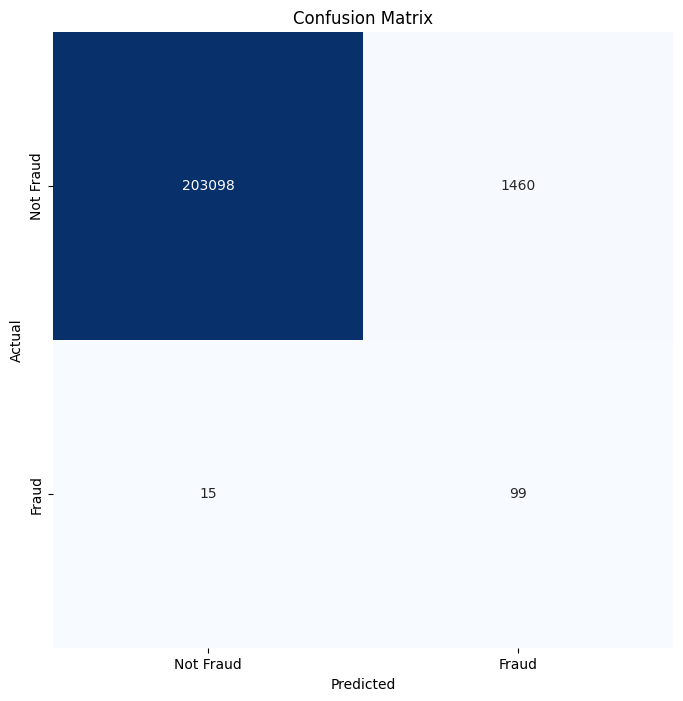

In [34]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2)+0.5, ['Not Fraud','Fraud'])
plt.yticks(np.arange(2)+0.5, ['Not Fraud','Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print('Classification Report:\n', clr)

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    204558
       Fraud       0.06      0.87      0.12       114

    accuracy                           0.99    204672
   macro avg       0.53      0.93      0.56    204672
weighted avg       1.00      0.99      1.00    204672



In [36]:
! git clone https://github.com/gradio-app/gradio.git


Cloning into 'gradio'...
remote: Enumerating objects: 130343, done.
remote: Counting objects: 100% (992/992), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 130343 (delta 747), reused 403 (delta 395), pack-reused 129351 (from 5)
Receiving objects: 100% (130343/130343), 292.71 MiB | 24.72 MiB/s, done.
Resolving deltas: 100% (93224/93224), done.
Updating files: 100% (3094/3094), done.


In [37]:
! ls gradio/

build_pypi.sh	    js			 renovate.json
CHANGELOG.md	    LICENSE		 requirements-mcp.txt
CITATION.cff	    package.json	 requirements-oauth.txt
client		    patches		 requirements.txt
CODE_OF_CONDUCT.md  pnpm-lock.yaml	 scripts
CONTRIBUTING.md     pnpm-workspace.yaml  SECURITY.md
demo		    pyproject.toml	 style.md
globals.d.ts	    readme_files	 svelte.config.js
gradio		    README.md		 test
guides		    readme_template.md	 testing-guidelines
home		    render_readme.py	 tsconfig.json


In [38]:
! python gradio/setup.py install

python3: can't open file '/content/gradio/setup.py': [Errno 2] No such file or directory


In [39]:
! pip install gradio

In [40]:
! python gradio/setup.py install

python3: can't open file '/content/gradio/setup.py': [Errno 2] No such file or directory


In [41]:
import gradio as gr

In [42]:
def dataframe(file_obj):
    df = pd.read_csv(file_obj.name)
    df = onehot(df, column='type', prefix='tp')
    df = df.drop(['nameOrig','nameDest','step'], axis=1)
    print(df.shape)
    y_pred = model.predict(df)

    pred_df = pd.DataFrame(y_pred, columns = ['isFraud'])
    print(type(pred_df))
    print(pred_df.shape)
#     clr = classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud'])
#     return 'Classification Report:\n'+ clr
    return pred_df


In [46]:
# =============================================================================
# Gradio Interface for Batch Fraud Prediction from CSV File
# =============================================================================

import gradio as gr

# Define file input: accept only a single CSV file
csv_input = gr.File(label="Upload Transaction CSV", file_types=[".csv"])

# Define DataFrame output: display prediction results
prediction_output = gr.Dataframe(label="Predicted Outcomes")

# Create Gradio Interface
fraud_detection_ui = gr.Interface(
    fn=dataframe,  # Make sure to define this function separately
    inputs=csv_input,
    outputs=prediction_output,
    title="📊 Mobile Money Fraud Detection System",
    description="Upload a CSV file with transaction records to detect potential fraud.",
    theme="soft"  # Use 'soft', 'default', or custom themes; 'dark-peach' may be unsupported
)

# Launch the interface
fraud_detection_ui.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b57ec1e60138fa2cc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [48]:
fraud_detection_ui.launch(share=True)


Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b57ec1e60138fa2cc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [49]:
y = np.array([0,1])
y[0]

np.int64(0)

In [50]:
# =============================================================================
# Single Transaction Fraud Prediction Function
# =============================================================================

def predict_transaction(trans_type, amount, old_balance_origin):
    """
    Predicts the likelihood of a single transaction being fraudulent
    based on transaction type, amount, and originator's old balance.
    """

    # Dynamically compute new originator balance based on transaction type
    balance_update_logic = {
        "PAYMENT": old_balance_origin - amount,
        "TRANSFER": old_balance_origin - amount,
        "CASH_OUT": old_balance_origin - amount,
        "CASH_IN":  old_balance_origin + amount,
        "DEBIT":    old_balance_origin - amount,
    }
    new_balance_origin = balance_update_logic.get(trans_type, 0.0)

    # Construct feature dictionary for the model
    sample = {
        'type': trans_type,
        'amount': amount,
        'oldbalanceOrg': old_balance_origin,
        'newbalanceOrig': new_balance_origin,
        'oldbalanceDest': 0.0,
        'newbalanceDest': 0.0,
        'tp_PAYMENT': 0,
        'tp_TRANSFER': 0,
        'tp_CASH_OUT': 0,
        'tp_CASH_IN': 0,
        'tp_DEBIT': 0
    }

    # Convert to DataFrame
    input_df = pd.DataFrame(sample, index=[0])

    # Remove the one-hot flag for the selected type (to be re-added properly)
    type_column_to_drop = f"tp_{trans_type}"
    if type_column_to_drop in input_df.columns:
        input_df = input_df.drop(columns=type_column_to_drop)

    # Apply one-hot encoding for 'type'
    input_df = onehot(input_df, column='type', prefix='tp')

    # Log processed input (for debugging)
    print("[DEBUG] Processed Input for Model:")
    print(input_df)

    # Run prediction using preloaded model
    probabilities = model.predict_proba(input_df)[0].tolist()

    # Create named probability output
    prediction = {
        "Not Fraud": probabilities[0],
        "Fraud": probabilities[1]
    }

    return prediction, new_balance_origin


In [51]:
# =============================================================================
# Gradio Interface for Real-Time Fraud Prediction (Single Transaction)
# =============================================================================

import gradio as gr

# Input components
transaction_type_input = gr.Dropdown(
    choices=['PAYMENT', 'TRANSFER', 'CASH_OUT', 'CASH_IN', 'DEBIT'],
    label="Transaction Type",
    value=None,
    interactive=True
)

transaction_amount_input = gr.Number(
    label="Transaction Amount",
    value=None
)

origin_balance_input = gr.Number(
    label="Originator's Old Balance",
    value=100000
)

# Output components
fraud_label_output = gr.Label(
    label="Fraud Prediction"
)

predicted_new_balance_output = gr.Textbox(
    label="Predicted New Balance (Originator)"
)

# Define interface
per_transaction_interface = gr.Interface(
    fn=predict_transaction,  # This should match your function name
    inputs=[transaction_type_input, transaction_amount_input, origin_balance_input],
    outputs=[fraud_label_output, predicted_new_balance_output],
    title="💸 Oddity: Intelligent Fraud Detection for Mobile Transactions",
    description=(
        "Mobile Money Transactions (MMTs) have revolutionized financial access, yet remain vulnerable to fraud. "
        "This tool predicts the likelihood of a transaction being fraudulent based on key parameters. "
        "Empowering users with AI-driven insights helps build a safer, more inclusive FinTech ecosystem."
    ),
    theme="soft"  # 'dark-peach' is not a supported Gradio v4+ theme. Use 'soft', 'default', or omit.
)


In [53]:
per_transaction_interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://386653367b8b456766.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Step-by-Step: Deploy Gradio App Permanently to Hugging Face **Spaces**

In [54]:
pip install gradio huggingface_hub


In [56]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Traceback (most recent call last):
  File "/usr/local/bin/huggingface-cli", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/commands/huggingface_cli.py", line 

In [58]:
!mkdir fraud-detection-app
%cd fraud-detection-app


/content/fraud-detection-app


In [60]:
import joblib

# Replace this with your actual trained model object
joblib.dump(model, "model.pkl")


['model.pkl']

In [61]:
import gradio as gr
import pandas as pd
import joblib

model = joblib.load("model.pkl")  # Ensure this file exists in the same directory

def onehot(df, column, prefix):
    one_hot = pd.get_dummies(df[column], prefix=prefix)
    df = df.drop(column, axis=1)
    return pd.concat([df, one_hot], axis=1)

def predict_transaction(trans_type, amount, old_balance_origin):
    balance_update = {
        "PAYMENT": old_balance_origin - amount,
        "TRANSFER": old_balance_origin - amount,
        "CASH_OUT": old_balance_origin - amount,
        "CASH_IN":  old_balance_origin + amount,
        "DEBIT":    old_balance_origin - amount,
    }
    new_balance_origin = balance_update.get(trans_type, 0.0)

    row = {
        'type': trans_type,
        'amount': amount,
        'oldbalanceOrg': old_balance_origin,
        'newbalanceOrig': new_balance_origin,
        'oldbalanceDest': 0.0,
        'newbalanceDest': 0.0,
        'tp_PAYMENT': 0,
        'tp_TRANSFER': 0,
        'tp_CASH_OUT': 0,
        'tp_CASH_IN': 0,
        'tp_DEBIT': 0
    }

    df = pd.DataFrame(row, index=[0])
    drop_col = f"tp_{trans_type}"
    if drop_col in df.columns:
        df = df.drop(columns=drop_col)
    df = onehot(df, 'type', 'tp')
    preds = model.predict_proba(df)[0].tolist()
    return {"Not Fraud": preds[0], "Fraud": preds[1]}, new_balance_origin

interface = gr.Interface(
    fn=predict_transaction,
    inputs=[
        gr.Dropdown(['PAYMENT','TRANSFER','CASH_OUT','CASH_IN','DEBIT'], label="Transaction Type"),
        gr.Number(label="Transaction Amount"),
        gr.Number(label="Originator's Old Balance", value=100000)
    ],
    outputs=[
        gr.Label(label="Fraud Probability"),
        gr.Textbox(label="Predicted New Balance")
    ],
    title="📊 Mobile Fraud Detection App",
    description="Upload transaction details and detect fraud in real time."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29d08251e6925d2b25.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Add Required Files



app.py — your main code (as above)
requirements.txt — dependencies:
gradio
pandas
scikit-learn
joblib
If you're using XGBoost or TensorFlow, add them as well.


In [ ]:
!gradio deploy


Need 'write' access token to create a Spaces repo.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): 

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2235, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1746, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

In [67]:
from huggingface_hub import notebook_login
notebook_login()
